In [1]:
import math
import datetime
import calendar

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import numpy as np
import itertools
import networkx as nx
from langdetect import detect

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

Florin:
Initial explorations :  5 grafice
in depth country analysis: 5 grafice
Maps:  6 grafice

David:
in depth movie analysis:  8 grafice
In depth tv show analysis: 4 grafice

Ioana:

tv show vs movie: 3 grafice
language analysis: 3 grafice
actors:  3 grafice
customer feedback: 1 grafic
romania:  2 grafice

In [2]:
# Color palette
theme = {
    "red": 'rgb(219,0,0)',
    "black": 'rgb(0,0,0)',
    "white": 'rgb(255,255,255)',
    "gray": 'rgb(86,77,77)',
    "dark_gray": 'rgb(30,30,30)',
    "light_gray": "rgb(150,150,150)",
    "light_red": 'rgb(131,16,16)',
    "red_hex": '#DB0000',
    "dark_gray_hex": '#1E1E1E',
    "light_gray_hex": "#969696",
}

def parse_time(string_time):
    try:
        clean = string_time.strip()
        parsed = datetime.datetime.strptime(clean, '%B %d, %Y')
        return int(parsed.year)

    except Exception as e:
        return 0

Load data from CSV (https://www.kaggle.com/shivamb/netflix-shows)

## Ioana Cirstoiu, Florin Iordache, David Ivan - Group 4 

We analyzed the most complete Netflix dataset on the Internet, which has 12 feature columns, containing data for shows on Netflix up until early 2021. 

We can say that this is not a difficult dataset, being organised nicely and not having lots of null values. The challenges we encountered when pre-processing the data had to do with the genre of the shows being comma-separated and, most important, with the lack of a feature describing user-feedback (a show rating of some sorts, perhaps).

In [3]:
dataframe = pd.read_csv('data.csv')
dataframe[0:3]

show_id     type  title           director  \
0      s1  TV Show     3%                NaN   
1      s2    Movie   7:19  Jorge Michel Grau   
2      s3    Movie  23:59       Gilbert Chan   

                                                cast    country  \
0  João Miguel, Bianca Comparato, Michel Gomes, R...     Brazil   
1  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...     Mexico   
2  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...  Singapore   

          date_added  release_year rating   duration  \
0    August 14, 2020          2020  TV-MA  4 Seasons   
1  December 23, 2016          2016  TV-MA     93 min   
2  December 20, 2018          2011      R     78 min   

                                           listed_in  \
0  International TV Shows, TV Dramas, TV Sci-Fi &...   
1                       Dramas, International Movies   
2                Horror Movies, International Movies   

                                         description  
0  In a future where the elite inhabit an island ...  
1  After a devastating earthquake hits Mexico Cit...  
2  When an army recruit is found dead, his fellow...

In [4]:
dataframe_copy = dataframe.copy()
dataframe_copy.dropna(subset=["description"], inplace=True)
all_descriptions = " ".join(description
                            for description in dataframe_copy.description)
all_descriptions = all_descriptions.replace(',', '')

In [56]:
by_genre = dataframe[[
    'title', 'country', 'date_added', 'release_year', 'listed_in', 'type'
]].copy()

by_genre = by_genre.sort_values(by=['country'])
by_genre = by_genre[by_genre['country'].notna()]
by_genre['country'] = by_genre['country'].apply(lambda x: str(x).split(", "))
by_genre = by_genre.explode('country')

by_genre['listed_in'] = by_genre['listed_in'].apply(
    lambda x: str(x).split(", "))

by_genre = by_genre.explode('listed_in')
movies = by_genre[by_genre['type'] == 'Movie'].copy()

Before applying different data visualization methods, some cleanup is necessary.

Because some movie titles are available in multiple countries and are listed as well, in multiple Netflix genres (listed_in column), by splitting these columns and adding new entries, we will have a better overview on the data. After this operation, there might be some residual initial white spaces, such as ' India' instead of 'India', therefore this case must be handled as well.

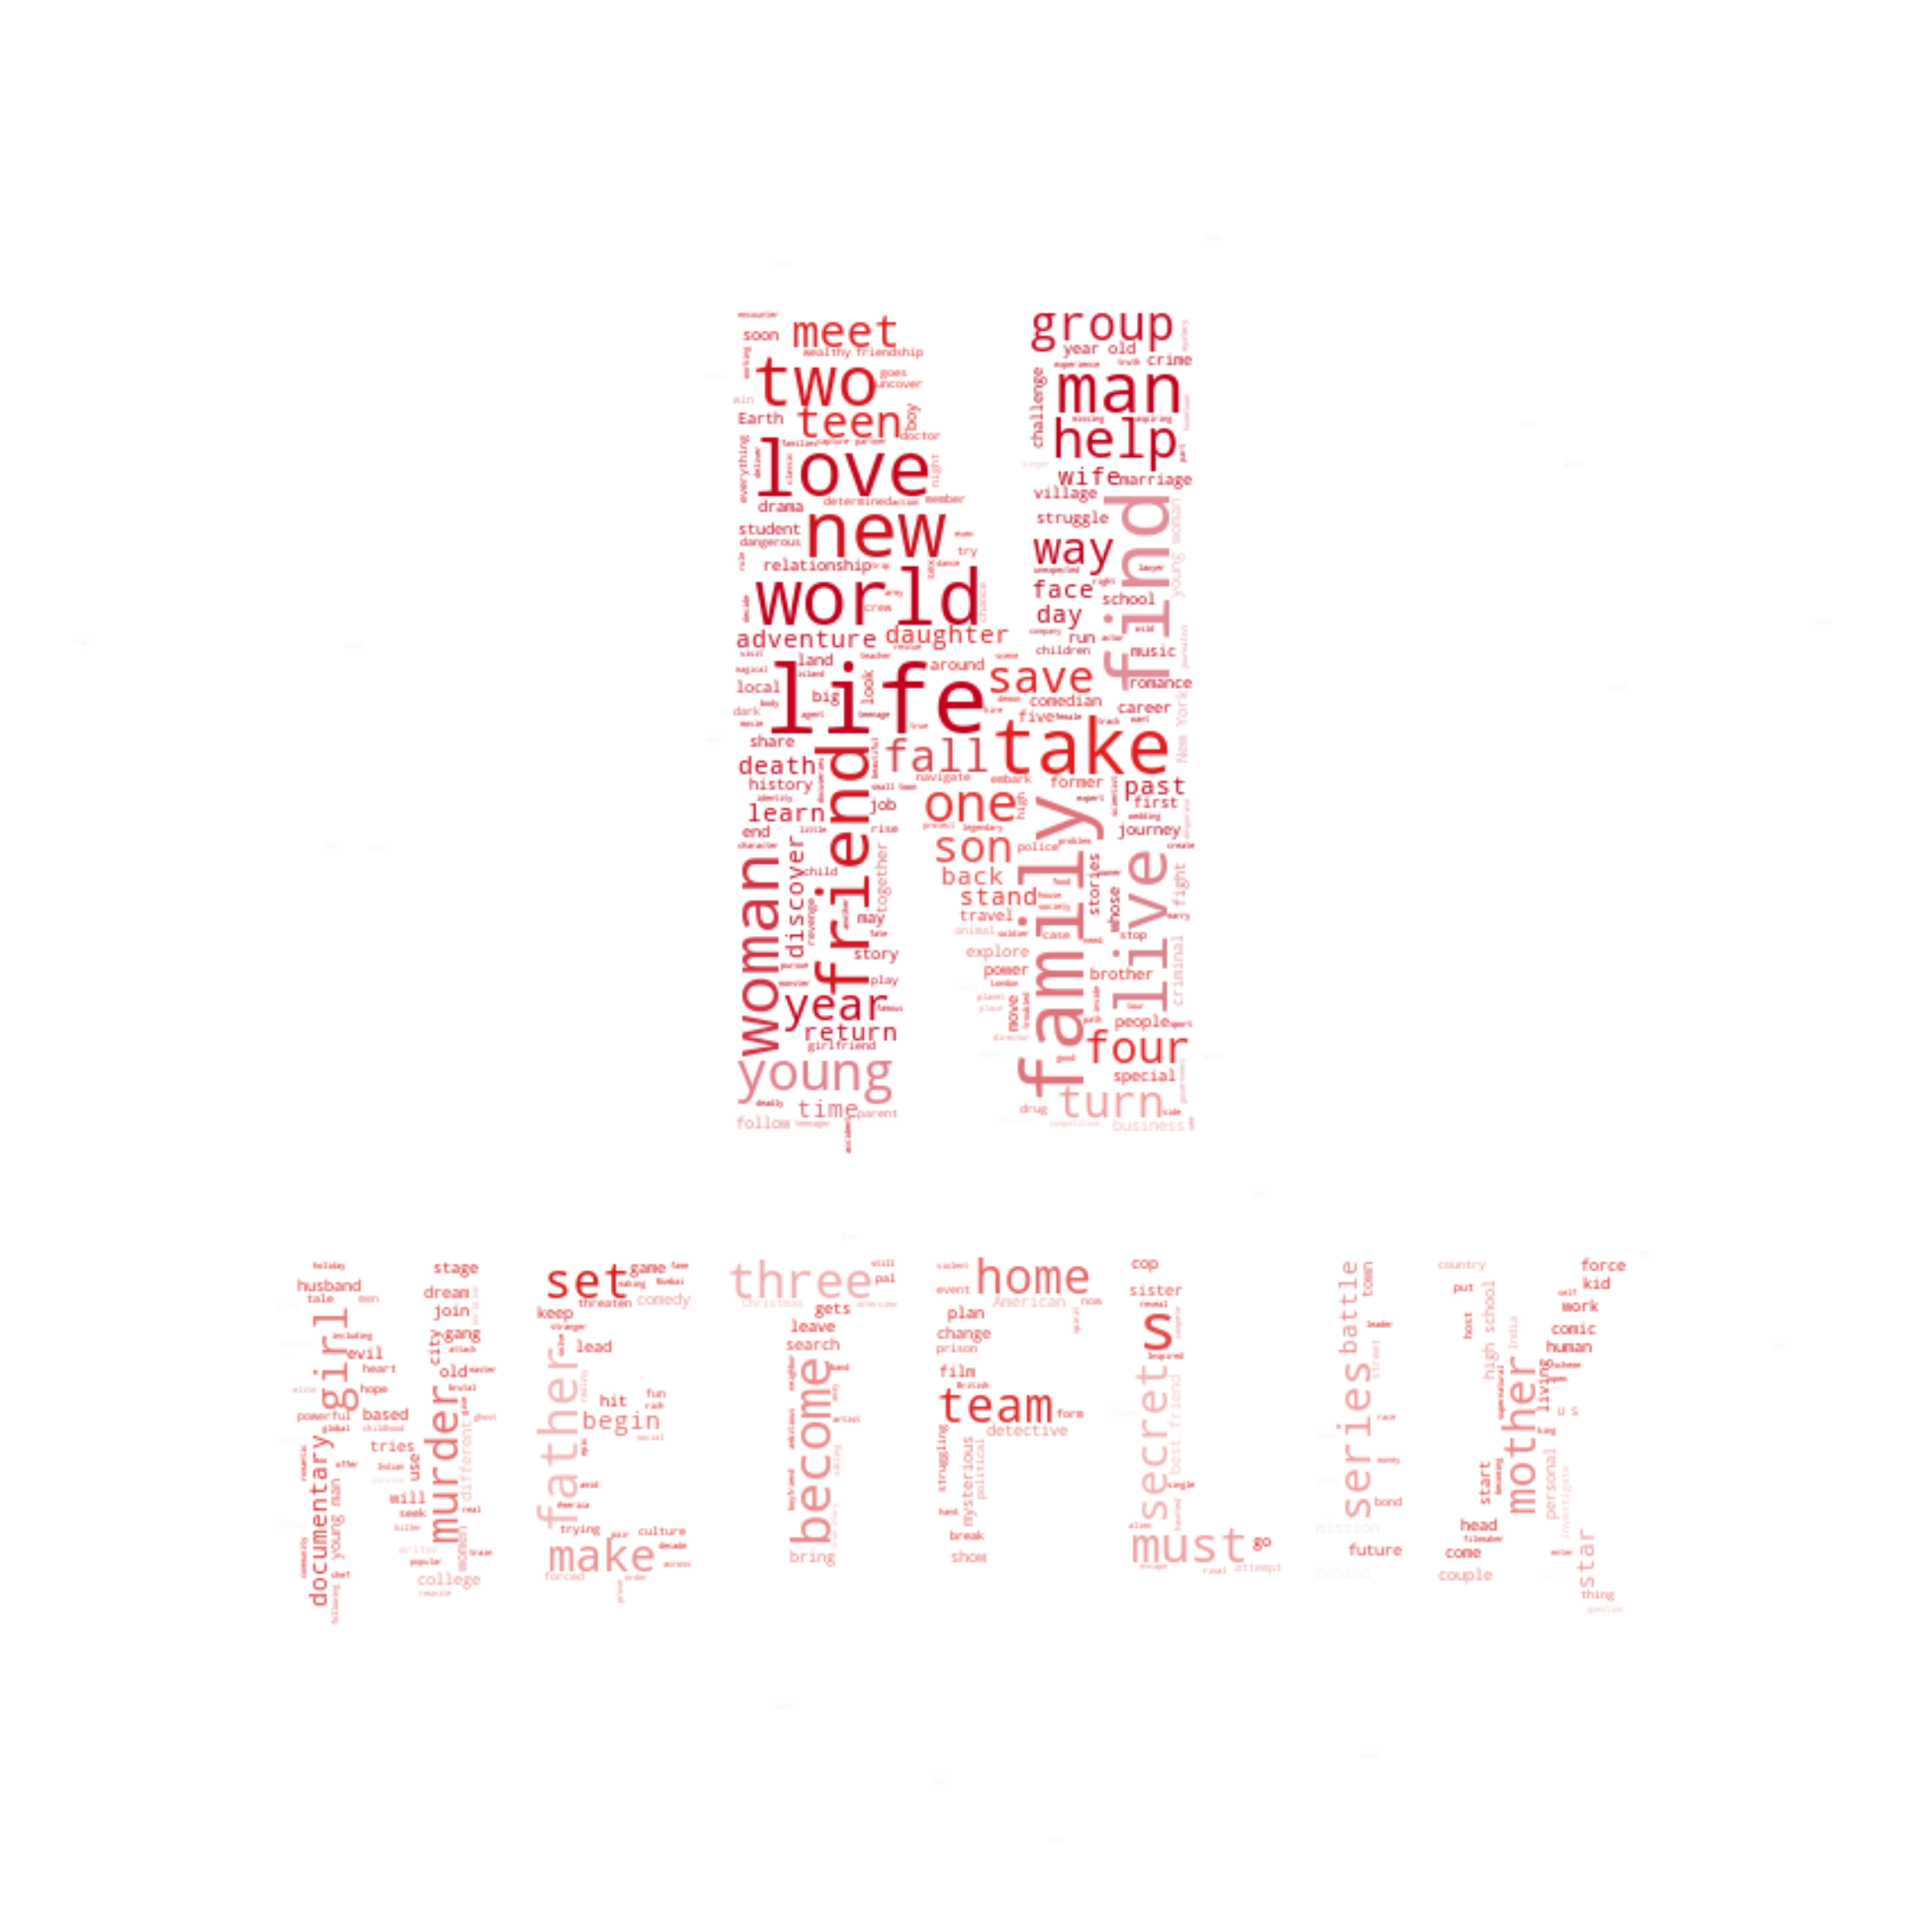

In [6]:
mask = np.array(Image.open('netflix_1.png'))
wordcloud_image = WordCloud(background_color="white",
                            mode="RGBA",
                            max_words=2000,
                            mask=mask,
                            width=5200,
                            height=3600).generate(all_descriptions)

image_generator = ImageColorGenerator(mask)
plt.figure(figsize=[40, 50])
plt.axis("off")
plt.imshow(wordcloud_image.recolor(color_func=image_generator),
           interpolation="bilinear")

This is a wordcloud of the most used words in the descriptions of the shows on Netflix. We can see that among the most used words we can find 'life, world, family and love', which correspond to non-fantasy shows. 'Teen' is another important keyword, because that indicated Netflix's tendency to create more shows oriented towards teens - confirmed also by words like 'young, student'.

## Initial explorations

First we want to see which productions have a country specified.

In [7]:
have_country = dataframe[pd.notnull(dataframe['country'])]
nb_total_productions = dataframe.shape[0]
nb_have_country = have_country.shape[0]
nb_without_country = nb_total_productions - nb_have_country
print("Total number of productions: ", nb_total_productions)
print("Total number of productions with specified country: ", nb_have_country)
print("Total number of productions without a specified country: ", nb_without_country)

Total number of productions:  7787
Total number of productions with specified country:  7280
Total number of productions without a specified country:  507


In [8]:
collabs = have_country['country'].str.contains(",")
nb_collabs = np.sum(collabs)
nb_not_collabs = np.sum(~collabs)

print("Productions made in country collaborations: ", nb_collabs)
print("Productions made by individudal countries: ", nb_not_collabs)

Productions made in country collaborations:  1153
Productions made by individudal countries:  6127


In [9]:
labels = ['Country not specified', 'Specified country']
values = [nb_without_country, nb_have_country]

fig = go.Figure(data=[
    go.Pie(labels=labels,
           values=values,
           marker_colors=[theme['light_gray'], theme['red']])
])
fig.update_layout(
    paper_bgcolor=theme['dark_gray'],
    plot_bgcolor=theme['dark_gray'],
    font_color="white",
    title={
        'text': "Number of productions with specified country",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
)
fig.show()

Let's see how many TV shows there are vs Movies from all the productions.

In [10]:
labels = ['TV Shows', 'Movies']
values = [
    dataframe[dataframe['type'] == 'TV Show'].shape[0],
    dataframe[dataframe['type'] == 'Movie'].shape[0]
]

fig = go.Figure(data=[
    go.Pie(labels=labels,
           values=values,
           marker_colors=[theme['light_gray'], theme['red']],
          textinfo='label+percent')
])
fig.update_layout(
    paper_bgcolor=theme['dark_gray'],
    plot_bgcolor=theme['dark_gray'],
    font_color="white",
    title={
        'text': "Total number of movies vs TV shows",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
)
fig.show()

For now, there are is a much bigger number of movies than TV shows in the Netflix catalogue. However, this thing is starting to change as the available time for watching TV shrinks. People nowadays have less and less consecutive minutes to watch TV because of the busy schedule of the modern world. That translates into a higher interest for TV shows, because it's much more feasible to find 50 free minutes every night rather than 100 consecutive minutes (the average length of a movie).  <a href="https://www.cinemablend.com/television/2486360/netflix-now-has-more-tv-shows-but-fewer-movies-than-5-years-ago-smart-trend" target="_blank">Source</a> 

In [11]:
categories = []
for i in range(len(dataframe)):
    categories.extend(dataframe.listed_in.iloc[i].split(','))

for i in range(len(categories)):
    categories[i] = categories[i].strip()

categories_dict = {}
for i in categories:
    categories_dict[i] = categories.count(i)

categories_dict = dict(
    sorted(categories_dict.items(), key=lambda entry: entry[1], reverse=True))

C:\Users\flori\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



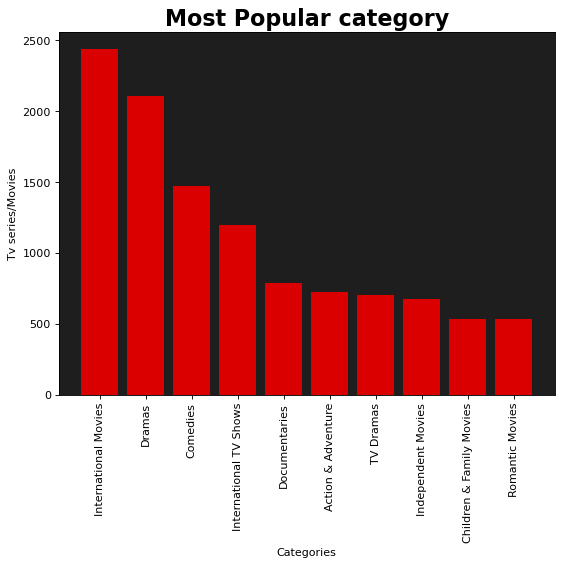

In [12]:
height = list(categories_dict.values())[:10]
bars = list(categories_dict.keys())[:10]
y_pos = np.arange(len(bars))
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(y_pos, height, color=theme['red_hex'])
ax = plt.axes()
ax.set_facecolor(theme['dark_gray_hex'])
plt.xlabel('Categories')
plt.xticks(y_pos, bars)
plt.ylabel('Tv series/Movies')
plt.title('Most Popular category', fontsize=20, fontweight='bold')

plt.xticks(rotation=90)

plt.show()

The most frequent category is also one of the most generic ones, since Netflix is labeling their shows with multiple labels per show. In second and third place come the usual suspects, with dramas being more present than commedies. 

<p>One interesting result is that Independent movies are more present than Children & Family movies and than Romantic Movies. This is interesting because it is known that Netflix is actively engaged in promoting and supporting independent movies, especially european movies. They even bought a bunch of Romanian movies as well, from different genres - comedy '<i>Miami Bici</i>', drama '<i>Ana, mon amour</i>', which is a way of funding future movies. </p> 

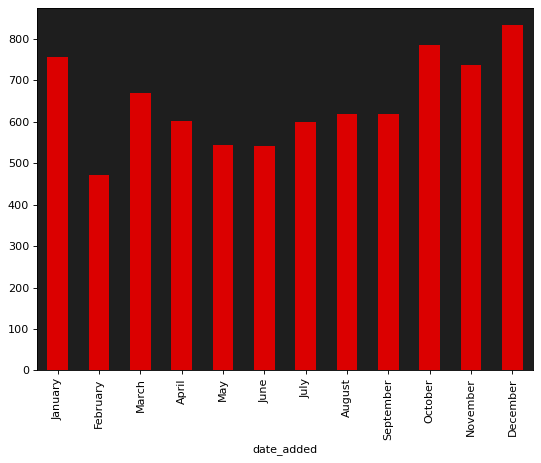

In [13]:
df_copy = dataframe.copy()

df_copy['date_added'] = pd.to_datetime(df_copy['date_added'])
months = [
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
    'September', 'October', 'November', 'December'
]
plt.figure(figsize=(8, 6), dpi=80)
plot = (df_copy.groupby(df_copy['date_added'].dt.strftime('%B'))
        ['show_id'].count().reindex(months).plot.bar(color=theme['red_hex']))
plot.set_facecolor(theme['dark_gray_hex'])

Let's check out how Netflix chooses their release month. We can see that the most shows are released during the late-autumn and early-winter, which is quite intuitive, since that's when most people tend to stay at home watching TV. 

Most shows are released during <b>December</b>, when the winter holidays are, with most people being out-of-office for the two weeks between Christmas and New Years Eve. October coming in as the second most preferred month might come as a surprise, but it's explainable by the fact that the US is the main market and producer for Netflix (see the plots below), and October it's the month of Halloween. and the start of the period when people tend to stay at home and watch TV because it gets colder outside.

In [14]:
netflix_df_filtered = df_copy.copy()
netflix_df_filtered['year'] = netflix_df_filtered['date_added'].dt.year.astype('Int64')
netflix_df_filtered['month'] = netflix_df_filtered['date_added'].dt.strftime('%B')
netflix_df_filtered = netflix_df_filtered.sort_values(by='month')
netflix_df_filtered = netflix_df_filtered.loc[
    (netflix_df_filtered['year'] >= 2017)
    & (netflix_df_filtered['year'] <= 2020)]
netflix_df_filtered.dropna(subset=["year"], inplace=True)

netflix_pivot = pd.pivot_table(netflix_df_filtered,
                               values='show_id',
                               index='year',
                               columns='month',
                               aggfunc='count',
                               fill_value=0)
netflix_pivot = netflix_pivot.reindex(months, axis=1)
netflix_pivot = netflix_pivot.T

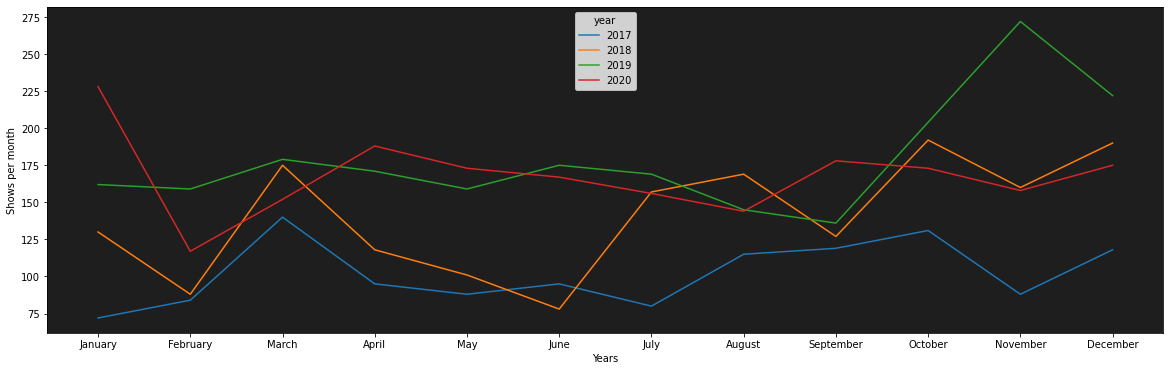

In [15]:
ax = netflix_pivot.plot(kind="line")

fig = ax.get_figure()
fig.set_size_inches(20, 6)
locs, labels = plt.xticks()
plt.xticks(np.arange(12),
           ('January', 'February', 'March', 'April', 'May', 'June', 'July',
            'August', 'September', 'October', 'November', 'December'))
ax.set_xlabel("Years")
ax.set_ylabel("Shows per month")
ax.set_facecolor(theme['dark_gray_hex'])

plt.show()

If we analyze the shows released in the last 4 years by their month of release, we can see that the tendency to release more shows during the autumn is persistent among the 4 years analyzed. We can see the effects of the Coronavirus in 2020, because the momentum gained at the end of 2019 went downhill by april 2020, because filming was canceled for lots of shows and movies. However, Netflix kept their tendency to release more shows in december, even if the number was lower than the one reached in 2019 and 2018.

## In depth country analysis 

Based on the initial explorations, we've decided that a good starting point for more in-depth analysis would be to analyze Netflix's business based on the production country of their shows.

In [16]:
labels = [
    'Productions made in country collaborations',
    'Productions made by individudal countries'
]
values = [nb_collabs, nb_not_collabs]

fig = go.Figure(data=[
    go.Pie(labels=labels,
           values=values,
           marker_colors=[theme['light_gray'], theme['red']])
])
fig.update_layout(
    paper_bgcolor=theme['dark_gray'],
    plot_bgcolor=theme['dark_gray'],
    font_color="white",
    title={
        'text':
        "Number of productions created in collaboration between countries",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    })
fig.show()

Let's try to create separated entries from the comma separated country values in order to obtain statistics about countries.

We will split country names by `,` and then use the `explode` method to expand the records which have multiple countries. 

In [17]:
by_country = have_country[['title', 'country', 'date_added',
                        'release_year']].copy()
by_country['country'] = by_country['country'].apply(lambda row_value: list(
    map(lambda country_name: country_name.strip(), str(row_value).split(","))))

expanded_countries = by_country.explode('country')

expanded_countries[0:3]

title    country         date_added  release_year
0     3%     Brazil    August 14, 2020          2020
1   7:19     Mexico  December 23, 2016          2016
2  23:59  Singapore  December 20, 2018          2011

Now we have separate record for each association `country - production`. We can use them for representation purpopses.


First, we can count how many productions are made by each country and sort them descending to find out which countries have the most productions added to the platform.

In [18]:
df_copy['date_added']

0      2020-08-14
1      2016-12-23
2      2018-12-20
3      2017-11-16
4      2020-01-01
          ...    
7782   2020-10-19
7783   2019-03-02
7784   2020-09-25
7785   2020-10-31
7786   2020-03-01
Name: date_added, Length: 7787, dtype: datetime64[ns]

In [19]:
df_copy_2 = dataframe.copy()
df_copy_2['year'] = df_copy_2['date_added'].apply(
    parse_time)
netflix_pivot_year = pd.pivot_table(df_copy_2,
                                    values='show_id',
                                    index='type',
                                    columns='year',
                                    aggfunc='count',
                                    fill_value=0)
netflix_pivot_year.head()

country_one_hot_df = dataframe_copy[["country"]]
country_one_hot_df.reset_index(drop=True, inplace=True)
country_one_hot_df = pd.concat([
    country_one_hot_df.drop('country', 1),
    country_one_hot_df['country'].str.get_dummies(sep=",")
], 1)

country_count_df = country_one_hot_df.agg(['sum'])
country_one_hot_df_wo_index = pd.DataFrame()
country_one_hot_df_wo_index = country_one_hot_df_wo_index.append(
    country_count_df,
    ignore_index=True,
)
country_one_hot_df_wo_index.reset_index(drop=True, inplace=True)

columns = country_one_hot_df_wo_index.columns
columns_no_space = []
for column in columns:
    if column[0] == ' ':
        column = column[1:]

    columns_no_space.append(column)

final_df = pd.DataFrame(columns_no_space, columns=['country'])
final_df['count'] = country_one_hot_df_wo_index.T.values
#final_df

fig = px.treemap(
    final_df,
    path=['country'],
    values='count',
)
fig.show()

The United States takes the first place in this leaderboard by far, followed by India. USA's advantage is that english has established itself as an universal language, so United States produced productions are seen in Europe as well, and less so in Asia as well. 

However, India occupying the second position is somewhat surprising for an european viewer, whose recommendations tend not to contain indian productions. However, India it's a very important market for Netflix (they entered the indian market in 2016 and have grown exponentially since). They have done so by making quality shows too, winning an Emmy prize with Delhi Crime. Despite that, Netflix still leads a battle between quality and quantity, which is helped by the Indian Internet becoming cheaper and cheaper. This makes access to Netflix more easier to less educated parts of the Indian population, which is satisfied by shows of a lesser quality.

Romania has 12 shows currently on Netflix. That's 3 more than Hungary and Bulgaria, but 3 times less than the 36 shows of Poland, for instance

Let's see how the number of US productions compare against number of productions made by other countries

In [20]:
country_counts = expanded_countries.groupby(by='country').title.agg(
    ["count"]).sort_values(['count'], ascending=False).reset_index()
nb_us_movies = country_counts[country_counts['country'] ==
                              'United States']['count'].sum()
nb_int_movies = country_counts[
    country_counts['country'] != 'United States']['count'].sum()
labels = ['Productions made by US', 'Productions made by other countries']
values = [nb_us_movies, nb_int_movies]

fig = go.Figure(data=[
    go.Pie(labels=labels,
           values=values,
           marker_colors=[theme['light_gray'], theme['red']])
])
fig.update_layout(paper_bgcolor=theme['dark_gray'],
                  plot_bgcolor=theme['dark_gray'],
                  font_color="white",
                  title={
                      'text': "Percentage of productions made by US",
                      'y': 0.95,
                      'x': 0.45,
                      'xanchor': 'center',
                      'yanchor': 'top'
                  })
fig.show()

Even though all the other countries combined make up a bigger part of all the total productions, US movie industry still has a significant part.


#### Number of productions added each year by producing country

Let's see how many productions have been added to Netflix each year from each country.


We need to extract the year in which each tv show/movie was added to Netflix from the `date_added` column.

In [21]:
expanded_countries['added_year'] = expanded_countries['date_added'].apply(
    parse_time)
with_year = expanded_countries[expanded_countries['added_year'] != 0]

with_year[0:3]

title    country         date_added  release_year  added_year
0     3%     Brazil    August 14, 2020          2020        2020
1   7:19     Mexico  December 23, 2016          2016        2016
2  23:59  Singapore  December 20, 2018          2011        2018

We need to get all the unique added_year values available in our dataframe.

In [22]:
years = sorted(expanded_countries['added_year'].unique())
#years

For each year, we count how many shows/movies are produced by each country and create one larger dataframe containing all aggregate data.

In [23]:
counts_by_year_and_country = pd.DataFrame()

for year in years:

    for_year = expanded_countries[
        expanded_countries['added_year'] < year].copy()

    for_year = for_year[['country', 'title']]

    counts_by_country = for_year.groupby(
        by='country', as_index=False).agg(number_of_titles=('title', 'count'))
    counts_by_country['added_year'] = str(year)
    counts_by_year_and_country = pd.concat(
        [counts_by_year_and_country, counts_by_country])

counts_by_year_and_country[0:3]

country  number_of_titles added_year
0       Australia                 1       2008
1           Japan                 1       2008
2  United Kingdom                 1       2008

From this dataframe we can see how many productions have been added from each country per year.

Let's see for example US.

In [24]:
us_movies = counts_by_year_and_country[counts_by_year_and_country['country'] == "United States"].reset_index(drop=True)
#us_movies[0:3]

In [25]:
fig = go.Figure(data=[
    go.Bar(x=us_movies['added_year'],
           y=us_movies['number_of_titles'],
           marker_color=theme['red'])
])
fig.update_layout(
    paper_bgcolor=theme['dark_gray'],
    plot_bgcolor=theme['dark_gray'],
    font_color="white",
    title={
        'text': "Netflix titles added every year produced by US",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
)
fig.show()

Since we know that the majority of the productions are from US, we want to see how the ratio `US productions vs international productions` evolved yearly.

Let's first extract all the yearly counts of productions made outside of US. 

In [26]:
int_movies = counts_by_year_and_country[counts_by_year_and_country['country'] != "United States"]
int_movies[0:3]

country  number_of_titles added_year
0       Australia                 1       2008
1           Japan                 1       2008
2  United Kingdom                 1       2008

Let's now count percentages of productions from US vs international productions on a yearly scale.

In [27]:
us_int_counts = {'added_year': [], 'us_movies': [], 'int_movies': []}

for year in years[1:]:
    us_int_counts['added_year'].append(year)
    us_counts = us_movies[us_movies["added_year"] == str(
        year)].number_of_titles.sum()
    int_counts = int_movies[int_movies["added_year"] == str(
        year)].number_of_titles.sum()

    us_percentage = round(us_counts * 100 / (us_counts + int_counts), 2)
    int_percentage = round(int_counts * 100 / (us_counts + int_counts), 2)
    us_int_counts['us_movies'].append(us_percentage)
    us_int_counts['int_movies'].append(int_percentage)

us_int_counts = pd.DataFrame(us_int_counts)
#us_int_counts

In [28]:
fig = go.Figure()
fig.add_trace(
    go.Bar(y=us_int_counts["us_movies"],
           x=us_int_counts['added_year'],
           name="US Movies %",
           marker={"color": 'rgb(219,0,0)'}))
fig.add_trace(
    go.Bar(y=us_int_counts["int_movies"],
           x=us_int_counts['added_year'],
           name="International Movies %",
           marker={"color": 'rgb(86,77,77)'}))

fig.update_layout(yaxis={
    "title_text": "Productions added %",
    "ticktext": ["0%", "20%", "40%", "60%", "80%", "100%"],
    "tickvals": [0, 20, 40, 60, 80, 100],
    "tickmode": "array",
    "titlefont": {
        "size": 16
    },
},
                  autosize=False,
                  paper_bgcolor=theme['dark_gray'],
                  plot_bgcolor=theme['dark_gray'],
                  title={
                      'text':
                      "US vs International movie industry on Netflix %",
                      'y': 0.85,
                      'x': 0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'
                  },
                  font_color='white',
                  barmode='stack')
fig.show()

### Maps 

The country analysis could not be complete without the context offered by geography. 

Production counts per year can also be displayed on a map using a choropleth visualization. For each country on the map, the color will correspond to the number of productions.

First let's see what the map looks like with productions added in year 2021.


In [29]:
last_year_counts = counts_by_year_and_country[counts_by_year_and_country['added_year'] == "2021"]
last_year_counts[0:3]

country  number_of_titles added_year
0                              4       2021
1  Afghanistan                 1       2021
2      Albania                 1       2021

In [30]:
px.choropleth(last_year_counts,
              locations="country",
              color="number_of_titles",
              hover_name="country",
              hover_data={
                  "country": False,
                  "number_of_titles": True,
                  "added_year": False,
              },
              locationmode='country names',
              color_continuous_scale='reds',
              height=600)

Again, US has a big part of all the movies and it makes the counts of other countries hard to be differentiated. Let's display a map of all the international productions.


In [31]:
px.choropleth(last_year_counts[last_year_counts['country'] != "United States"],
              locations="country",
              color="number_of_titles",
              hover_name="country",
              hover_data={
                  "country": False,
                  "number_of_titles": True,
                  "added_year": False,
              },
              locationmode='country names',
              color_continuous_scale='reds',
              height=600)

Now we can plot this data on a map and also assign the `animation_frame` property to be the `added_year` column such that we can change the currently displayed year of country counts.

In [32]:
px.choropleth(counts_by_year_and_country,
              locations="country",
              color="number_of_titles",
              hover_name="country",
              hover_data={
                  "country": False,
                  "number_of_titles": True,
                  "added_year": False,
              },
              locationmode='country names',
              animation_frame="added_year",
              color_continuous_scale='reds',
              height=600)

And without US.

In [33]:
px.choropleth(counts_by_year_and_country[counts_by_year_and_country['country'] != "United States"],
              locations="country",
              color="number_of_titles",
              hover_name="country",
              hover_data={
                  "country": False,
                  "number_of_titles": True,
                  "added_year": False,
              },
              locationmode='country names',
              animation_frame="added_year",
              color_continuous_scale='reds',
              height=600)

In [61]:
movies = by_genre[by_genre['type'] == 'Movie'].copy()

movies_by_genre = movies.groupby(
    ['country'], as_index=False).agg(number_of_titles=('country', 'count'))
movies_by_genre

genres = [
    'International Movies', 'Stand-Up Comedy', 'Romantic Movies',
    'Music & Musicals', 'Movies'
]

# movies_by_genre = movies.groupby(
#     ['country'], as_index=False).agg(number_of_titles=('country', 'count'))
# movies_by_genre

In [62]:
for genre in genres:
    normalized_df = pd.DataFrame({'country': [], 'total_movies': []})
    movies_by_genre = movies[movies['listed_in'] == genre]

    movies_by_genre = movies_by_genre.groupby(
        ['country'], as_index=False).agg(number_of_titles=('country', 'count'))
    for index, row in movies_by_genre.iterrows():
        country = row['country']
        country_movies = movies[movies['country'] ==
                                country]['country'].count()
        genre_country_movies = movies_by_genre[movies_by_genre['country'] ==
                                               country]['number_of_titles']
        normalized_percentage = genre_country_movies.values[0] / country_movies
        new_row = {'country': country, 'total_movies': normalized_percentage}
        normalized_df = normalized_df.append(new_row, ignore_index=True)

    normalized_df = normalized_df.round({'total_movies': 2})
    normalized_df

    fig = px.choropleth(normalized_df,
                        locations="country",
                        title=genre,
                        color="total_movies",
                        hover_name="country",
                        hover_data={
                            "country": False,
                            "total_movies": True,
                        },
                        locationmode='country names',
                        color_continuous_scale='reds',
                        height=700)
    fig.show()

We think it's interesting to notice Russia's preoccupation to musicals, and to romantic movies, where we tought that South America will be much more represented (remember the soap operas of 2000 in Romania ?). However, it seems like South America is now all about stand-up commedy.

In [60]:
shows = by_genre[by_genre['type'] == 'TV Show'].copy()
shows_by_genre = shows.groupby(['country'],
                               as_index=False).agg(number_of_titles=('country',
                                                                     'count'))

show_genres = [
    'Spanish-Language TV Shows', 'TV Shows', 'TV Dramas', 'Reality TV',
    'TV Thrillers'
]
for genre in show_genres:
    normalized_df = pd.DataFrame({'country': [], 'total_shows': []})
    movies_by_genre = shows[shows['listed_in'] == genre]

    movies_by_genre = movies_by_genre.groupby(
        ['country'], as_index=False).agg(number_of_titles=('country', 'count'))
    for index, row in movies_by_genre.iterrows():
        country = row['country']
        country_movies = shows[shows['country'] == country]['country'].count()
        genre_country_movies = movies_by_genre[movies_by_genre['country'] ==
                                               country]['number_of_titles']
        normalized_percentage = genre_country_movies.values[0] / country_movies
        new_row = {'country': country, 'total_shows': normalized_percentage}

        normalized_df = normalized_df.append(new_row, ignore_index=True)

    normalized_df = normalized_df.round({'total_shows': 2})
    normalized_df

    fig = px.choropleth(normalized_df,
                        locations="country",
                        title=genre,
                        color="total_shows",
                        hover_name="country",
                        hover_data={
                            "country": False,
                            "total_shows": True,
                        },
                        locationmode='country names',
                        color_continuous_scale='reds',
                        height=700)
    fig.show()

It comes to nobody's surprise that Spanish-Language TV Shows are most popular in Mexico, South America and Spain. What's really interesting is the Northern Europe prefference for thrillers, with the likes of <i>Twin Peaks</i> really coming to our mind. 

Also interesting is that Reality TV is only popular in United Kingdom and Germany when it comes to Europe, but it is hugely popular in the Americas and in Australia as well. Perhaps that's because Reality TV in the rest of Europe isn't as well known as the one in the above mentioned countries, so it's not worth buying for Netflix.

### In-depth movie analysis 

Let's continue our journey by observing some stats regarding movies alone. 

We want to find out what is the average duration of movies.

For that we first need to extract movies from our dataset.


In [64]:
movies = dataframe[dataframe['type'] == 'Movie'].copy()
movies[0:3]

show_id   type  title           director  \
1      s2  Movie   7:19  Jorge Michel Grau   
2      s3  Movie  23:59       Gilbert Chan   
3      s4  Movie      9        Shane Acker   

                                                cast        country  \
1  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico   
2  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...      Singapore   
3  Elijah Wood, John C. Reilly, Jennifer Connelly...  United States   

          date_added  release_year rating duration  \
1  December 23, 2016          2016  TV-MA   93 min   
2  December 20, 2018          2011      R   78 min   
3  November 16, 2017          2009  PG-13   80 min   

                                           listed_in  \
1                       Dramas, International Movies   
2                Horror Movies, International Movies   
3  Action & Adventure, Independent Movies, Sci-Fi...   

                                         description  
1  After a devastating earthquake hits Mexico Cit...  
2  When an army recruit is found dead, his fellow...  
3  In a postapocalyptic world, rag-doll robots hi...

Convert the duration column from string x min to the number x and also convert it to integer.

In [65]:
movies['duration'] = movies['duration'].apply(lambda x: int(x.split()[0]))
movies[0:3]

show_id   type  title           director  \
1      s2  Movie   7:19  Jorge Michel Grau   
2      s3  Movie  23:59       Gilbert Chan   
3      s4  Movie      9        Shane Acker   

                                                cast        country  \
1  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico   
2  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...      Singapore   
3  Elijah Wood, John C. Reilly, Jennifer Connelly...  United States   

          date_added  release_year rating  duration  \
1  December 23, 2016          2016  TV-MA        93   
2  December 20, 2018          2011      R        78   
3  November 16, 2017          2009  PG-13        80   

                                           listed_in  \
1                       Dramas, International Movies   
2                Horror Movies, International Movies   
3  Action & Adventure, Independent Movies, Sci-Fi...   

                                         description  
1  After a devastating earthquake hits Mexico Cit...  
2  When an army recruit is found dead, his fellow...  
3  In a postapocalyptic world, rag-doll robots hi...

Group movies by their release year and compute average, minimum and maximum durations

In [66]:
duration_per_year = movies.groupby(by='release_year', as_index=False).agg(
    num_movies=('show_id', 'count'),
    average_duration=('duration', 'mean'),
    min_duration=('duration', 'min'),
    max_duration=('duration', 'max'))
duration_per_year[0:3]

release_year  num_movies  average_duration  min_duration  max_duration
0          1942           2         35.000000            18            52
1          1943           3         62.666667            45            82
2          1944           3         52.000000            40            76

In [67]:
fig = go.Figure(data=[
    go.Bar(x=duration_per_year['release_year'],
           y=duration_per_year['num_movies'],
           marker_color=theme['red'])
])
fig.update_layout(
    paper_bgcolor=theme['dark_gray'],
    plot_bgcolor=theme['dark_gray'],
    font_color="white",
    title={
        'text': "Release year of all movies available on Netflix",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
)
fig.show()

It looks like most of the movies are released after year 2000 so we will only use these ones in oroder to have correct metrics  

In [68]:
recent_movies = duration_per_year[duration_per_year['release_year'] > 2000].copy()
recent_movies[0:3]

release_year  num_movies  average_duration  min_duration  max_duration
51          2001          32        118.875000            42           224
52          2002          39        118.871795            78           179
53          2003          40        117.125000            37           201

In [69]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=recent_movies['release_year'],
               y=recent_movies['average_duration'],
               name='Average duration',
               mode='lines+markers',
               line={
                   "color": theme['red'],
                   "width": 4,
               }))
fig.add_trace(
    go.Scatter(x=recent_movies['release_year'],
               y=recent_movies['min_duration'],
               name='Minimum duration',
               mode='lines+markers',
               line={
                   "color": 'royalblue',
                   "width": 4,
                   "dash": 'dot'
               }))

fig.add_trace(
    go.Scatter(x=recent_movies['release_year'],
               y=recent_movies['max_duration'],
               name='Maximum duration',
               mode='lines+markers',
               line={
                   "color": 'green',
                   "width": 4,
                   "dash": 'dot'
               }))

fig.update_layout(
    paper_bgcolor=theme['dark_gray'],
    plot_bgcolor=theme['dark_gray'],
    font_color='white',
    title='Duration of movies from the Netflix collection by release year',
    xaxis_title='Release year',
    yaxis_title='Duration (minutes)')

fig.show()

We wanted to check the hypothesis (<a href="https://towardsdatascience.com/are-new-movies-longer-than-they-were-10hh20-50-year-ago-a35356b2ca5b" target="_blank">Source</a>) that the average length of movies is around 100 minutes. We have confirmed the hypothesis, with the most frequent duration being around 85 minutes. We think that's explainable because Netflix has lots of movies 'made for TV', which are usually much shorter than the ones produced especially for cinema. Think of Tarantino's movies, which are, on average 140 minutes long, or about Marvel movies (an average of 130 minutes as of 2019  (<a href="https://www.quora.com/What-is-the-total-runtime-of-all-the-Marvel-films-in-the-MCU-so-far-released." target="_blank">Source</a>)

We talked about predicting the future, so let's now try and apply a machine learning model to predict how will the average movie duration evolve in the next 5 years. 

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


x = recent_movies['release_year'].values.reshape(-1, 1)
y = recent_movies['average_duration'].values

model = make_pipeline(StandardScaler(), LinearRegression())

model.fit(x, y)

x_future = np.arange(2021, 2026)
y_future = model.predict(x_future.reshape(-1, 1))

In [71]:
fig = go.Figure()

fig.add_traces(
    go.Scatter(x=x_future,
               y=y_future.reshape(-1, ),
               name='Regression Line',
               line={
                   "color": theme['red'],
                   "width": 2,
                   "dash": "dashdot"
               }))


fig.update_layout(
    paper_bgcolor=theme['dark_gray'],
    plot_bgcolor=theme['dark_gray'],
    font_color='white',
    title='Regression line for average movie duration for next 5 years',
    xaxis_title='Release year',
    yaxis_title='Duration (minutes)',
    yaxis_range=[60,120],
    xaxis_range=[2021,2025],
    xaxis_tickvals=np.arange(2021,2026),
)

fig.show()

We can see that the average duration of a movie is predicted to decrease. We think that's logical in the fast paced world of today, were human beings tend to have less and less patience and more and more apetite for instant gratification.

In [72]:
by_genre['country'] = by_genre['country'].astype(str)
for index, row in by_genre.iterrows():
    if(str(row['country']) != '' and str(row['country'])[0] == ' '):
        strr = row['country'][1:]
        row['country'] = strr
        by_genre.at[index, 'country'] = strr
by_genre['listed_in'] = by_genre['listed_in'].astype(str)
for index, row in by_genre.iterrows():
    if(str(row['listed_in']) != '' and str(row['listed_in'])[0] == ' '):
        strr = row['listed_in'][1:]
        row['listed_in'] = strr
        by_genre.at[index, 'listed_in'] = strr

In [73]:
grouped_movies =  by_genre[by_genre['type'] == 'Movie'].groupby(
    ['listed_in'], as_index=False).agg(number_of_titles=('listed_in', 'count'))

grouped_movies = grouped_movies.sort_values(by=['number_of_titles'],
                                            ascending=False)
grouped_movies

listed_in  number_of_titles
11      International Movies              3027
7                     Dramas              2713
4                   Comedies              1704
6              Documentaries               978
0         Action & Adventure               977
10        Independent Movies               896
19                 Thrillers               672
2   Children & Family Movies               657
15           Romantic Movies               612
9              Horror Movies               395
14          Music & Musicals               344
16          Sci-Fi & Fantasy               330
18           Stand-Up Comedy               301
17             Sports Movies               236
3             Classic Movies               132
12              LGBTQ Movies               106
5                Cult Movies                78
8       Faith & Spirituality                73
1             Anime Features                61
13                    Movies                50

In [74]:
values = np.array(grouped_movies['number_of_titles'])
labels = np.array(grouped_movies['listed_in'])
number_of_elements = grouped_movies['listed_in'].count()
parents = []

for i in range(0, number_of_elements):
    parents.append('Movie genres') 

fig = go.Figure(go.Treemap(
    labels = labels,
    parents = parents,
    values =  values,
    textinfo = "value+label",
    ))

fig.update_layout(height=800, width=950)
fig.show()

It's reasonable for 'international movies' to be the largest category, since it's the most inclusive as well (keep in mind that the movies can belong to more than one category). It's interesting that there are more movies than comedies, and more sports movies than documentaries. 

In [75]:
movies_grouped_by_release_year = movies.groupby(
    ['release_year'],
    as_index=False).agg(number_of_titles=('listed_in', 'count'))
movies_grouped_by_release_year = movies_grouped_by_release_year.sort_values(
    by=['release_year'])
movies_grouped_by_release_year[0:3]

release_year  number_of_titles
0          1942                 2
1          1943                 3
2          1944                 3

In [76]:
movies['added_datetime'] = pd.to_datetime(movies['date_added'])
movies['added_year'] = pd.DatetimeIndex(movies['added_datetime']).year

movies_grouped_by_added_year = movies.groupby(
    ['added_year'],
    as_index=False).agg(number_of_titles=('listed_in', 'count'))
movies_grouped_by_added_year = movies_grouped_by_added_year.sort_values(
    by=['added_year'])
movies_grouped_by_added_year[0:3]

added_year  number_of_titles
0        2008                 1
1        2009                 2
2        2010                 1

In [77]:
release_years = movies_grouped_by_release_year['release_year'].values
added_years = movies_grouped_by_added_year['added_year'].values
years = np.union1d(release_years, added_years)

years_df = pd.DataFrame({
    'year': [],
    'added_movies': [],
    'released_movies': []
})
for year in years:
    number_of_added_movies = 0
    number_of_released_movies = 0
    added_movies = movies_grouped_by_added_year[
        movies_grouped_by_added_year['added_year'] ==
        year]['number_of_titles'].values
    if len(added_movies) == 0:
        number_of_added_movies = 0
    else:
        number_of_added_movies = added_movies[0]

    released_movies = movies_grouped_by_release_year[
        movies_grouped_by_release_year['release_year'] ==
        year]['number_of_titles'].values
    if len(released_movies) == 0:
        number_of_released_movies = 0
    else:
        number_of_released_movies = released_movies[0]
    new_row = {
        'year': year,
        'added_movies': number_of_added_movies,
        'released_movies': number_of_released_movies
    }
    years_df = years_df.append(new_row, ignore_index=True)

years_df['year'] = years_df['year'].astype(int)

years_df['added_movies'] = years_df['added_movies'].astype(int)
years_df['released_movies'] = years_df['released_movies'].astype(int)
years_df[-5:]

year  added_movies  released_movies
67  2017           864              744
68  2018          1255              734
69  2019          1497              582
70  2020          1312              411
71  2021            88               12

In [78]:
filtered_years_df = years_df[years_df['year'] > 2000]
filtered_years_df

fig = go.Figure(data=[
    go.Bar(name='Released movies',
           x=filtered_years_df['year'],
           y=filtered_years_df['released_movies']),
    go.Bar(name='Added movies',
           x=filtered_years_df['year'],
           y=filtered_years_df['added_movies'],
           marker_color=theme['red'])
])

fig.update_layout(barmode='group')
fig.update_layout(height=650)
fig.update_layout(paper_bgcolor=theme['dark_gray'],
                  plot_bgcolor=theme['dark_gray'],
                  font_color="white")
fig.update_layout(title_text='Released movies versus added movies')
fig.show()

The movies have been mostly added in the latest 5 years, but their release date has a wide range. However, most of the movies have the release year closer to current year.

In [79]:
netflix_productions = movies[movies['added_year'] ==
                             movies['release_year']].copy()
netflix_productions[0:3]

show_id   type title           director  \
1       s2  Movie  7:19  Jorge Michel Grau   
8       s9  Movie   706      Shravan Kumar   
10     s11  Movie  1922       Zak Hilditch   

                                                 cast        country  \
1   Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico   
8   Divya Dutta, Atul Kulkarni, Mohan Agashe, Anup...          India   
10  Thomas Jane, Molly Parker, Dylan Schmid, Kaitl...  United States   

           date_added  release_year rating  duration  \
1   December 23, 2016          2016  TV-MA        93   
8       April 1, 2019          2019  TV-14       118   
10   October 20, 2017          2017  TV-MA       103   

                              listed_in  \
1          Dramas, International Movies   
8   Horror Movies, International Movies   
10                    Dramas, Thrillers   

                                          description added_datetime  \
1   After a devastating earthquake hits Mexico Cit...     2016-12-23   
8   When a doctor goes missing, his psychiatrist w...     2019-04-01   
10  A farmer pens a confession admitting to his wi...     2017-10-20   

    added_year  
1         2016  
8         2019  
10        2017

In [80]:
grouped_netflix_productions = netflix_productions.groupby(
    ['release_year'],
    as_index=False).agg(number_of_titles=('release_year', 'count'))

grouped_netflix_productions[0:3]

release_year  number_of_titles
0          2009                 1
1          2012                 1
2          2013                 5

In [81]:
fig = go.Figure(
    go.Bar(x=grouped_netflix_productions['release_year'],
           y=grouped_netflix_productions['number_of_titles'],
           marker_color=theme['red']))

fig.update_layout(height=600)
fig.update_layout(paper_bgcolor=theme['dark_gray'],
                  plot_bgcolor=theme['dark_gray'],
                  font_color="white")
fig.update_xaxes(dtick="Y1", tickformat="Y", ticklabelmode="period")
fig.update_layout(title_text='Netflix original movies')
fig.show()

We computed Netflix's original movies by considering that the movies added in the same year they were released to public are made by Netflix. We can see that they decided to reach a plateau of about 840 Netflix originals movies per year. What's even more interesting is that the number of released shows in 2020 was not affected by the Covid-19 situation.

In [82]:
movies_added_in_2019 = movies[movies['added_year'] == 2019].copy()
#movies_added_in_2019

grouped_movies_added_in_2019 = movies_added_in_2019.groupby(
    ['release_year'],
    as_index=False).agg(number_of_titles=('listed_in', 'count'))
grouped_movies_added_in_2019 = grouped_movies_added_in_2019.sort_values(
    by=['number_of_titles'], ascending=False)
grouped_movies_added_in_2019.head()

release_year  number_of_titles
56          2019               384
55          2018               283
54          2017               124
53          2016                89
52          2015                52

In [83]:
fig = go.Figure(
    go.Bar(x=grouped_movies_added_in_2019['release_year'],
           y=grouped_movies_added_in_2019['number_of_titles'],
           marker_color=theme['red']))

fig.update_layout(height=700)
fig.update_layout(paper_bgcolor=theme['dark_gray'],
                  plot_bgcolor=theme['dark_gray'],
                  font_color="white")

fig.update_xaxes(tickmode='array', tickvals=list(range(1960, 2020, 5)))
fig.update_layout(title_text='Release year for movies added in 2019')
fig.show()

In [84]:
grouped_by_release_year = movies.groupby(
    ['release_year'],
    as_index=False).agg(number_of_titles=('listed_in', 'count'))

grouped_by_release_year = grouped_by_release_year.sort_values(
    by=['number_of_titles'], ascending=False)
grouped_by_release_year.head()

release_year  number_of_titles
67          2017               744
68          2018               734
66          2016               642
69          2019               582
70          2020               411

In [85]:
fig = go.Figure(
    go.Bar(x=grouped_by_release_year['release_year'],
           y=grouped_by_release_year['number_of_titles'],
           marker_color=theme['red']))

fig.update_layout(height=700)
fig.update_layout(paper_bgcolor=theme['dark_gray'],
                  plot_bgcolor=theme['dark_gray'],
                  font_color="white")
fig.update_layout(title_text='Release year for all movies on Netflix')
fig.show()

The switch in 2019 seems of interest, since that seems to be the moment when Netflix decided to invest more in their shows rather than in movies, perhaps considering that TV shows are the future, which comes as a surprise considering the exponential growth up until 2018. 

### In-depth TV Shows analysis 

It's now time for an in-depth analysis of the TV Shows released and bought by Netflix.

In [86]:
shows = by_genre[by_genre['type'] == 'TV Show'].copy()
shows[0:3]

title    country         date_added  release_year  \
4495  No Time for Shame  Argentina  November 19, 2019          2019   
4495  No Time for Shame  Argentina  November 19, 2019          2019   
4495  No Time for Shame  Argentina  November 19, 2019          2019   

                      listed_in     type  
4495     International TV Shows  TV Show  
4495                 Reality TV  TV Show  
4495  Spanish-Language TV Shows  TV Show

In [87]:
grouped_shows = shows.groupby(
    ['listed_in'], as_index=False).agg(number_of_titles=('listed_in', 'count'))

grouped_shows = grouped_shows.sort_values(by=['number_of_titles'],
                                          ascending=False)
grouped_shows[0:3]

listed_in  number_of_titles
5   International TV Shows              1147
15               TV Dramas               707
14             TV Comedies               508

In [88]:
shows_values = np.array(grouped_shows['number_of_titles'])
shows_labels = np.array(grouped_shows['listed_in'])
shows_number_of_elements = grouped_shows['listed_in'].count()
shows_parents = []

for i in range(0, shows_number_of_elements):
    shows_parents.append('Genres')

fig = go.Figure(
    go.Treemap(
        labels=shows_labels,
        parents=shows_parents,
        values=shows_values,
        textinfo="value+label",
    ))

fig.update_layout(height=800, width=950)
fig.show()

It comes to no surprise that Dramas is the most popular genre when it comes to TV Shows. However, the rise of Reality TV productions produced by Netflix is to be noted, especially when it comes to the last few years. Another notable think is the 'Korean TV Shows' category, which are so far apart than other TV Shows that they have their own category, the only one specific to a single country.

In [90]:
shows['added_datetime'] = pd.to_datetime(shows['date_added'])
shows['added_year'] = pd.DatetimeIndex(shows['added_datetime']).year

shows_grouped_by_added_year = shows.groupby(
    ['added_year'],
    as_index=False).agg(number_of_titles=('listed_in', 'count'))
shows_grouped_by_release_year = shows.groupby(
    ['release_year'],
    as_index=False).agg(number_of_titles=('listed_in', 'count'))
shows_grouped_by_release_year = shows_grouped_by_release_year.sort_values(
    by=['release_year'])
# shows_grouped_by_release_year
shows_grouped_by_added_year = shows.groupby(
    ['added_year'],
    as_index=False).agg(number_of_titles=('listed_in', 'count'))
shows_grouped_by_added_year = shows_grouped_by_added_year.sort_values(
    by=['added_year'])
shows_grouped_by_added_year

release_years = shows_grouped_by_release_year['release_year'].values
release_years

added_years = shows_grouped_by_added_year['added_year'].values
added_years
years = np.union1d(release_years, added_years)
years

years_df = pd.DataFrame({
    'year': [],
    'added_shows': [],
    'released_shows': []
})
for year in years:
    number_of_added_shows = 0
    number_of_released_shows = 0
    added_shows = shows_grouped_by_added_year[
        shows_grouped_by_added_year['added_year'] ==
        year]['number_of_titles'].values
    if len(added_shows) == 0:
        number_of_added_shows = 0
    else:
        number_of_added_shows = added_shows[0]

    released_shows = shows_grouped_by_release_year[
        shows_grouped_by_release_year['release_year'] ==
        year]['number_of_titles'].values
    if len(released_shows) == 0:
        number_of_released_shows = 0
    else:
        number_of_released_shows = released_shows[0]
    new_row = {
        'year': year,
        'added_shows': number_of_added_shows,
        'released_shows': number_of_released_shows
    }
    years_df = years_df.append(new_row, ignore_index=True)

years_df['year'] = years_df['year'].astype(int)

years_df['added_shows'] = years_df['added_shows'].astype(int)
years_df['released_shows'] = years_df['released_shows'].astype(int)
years_df

filtered_years_df = years_df[years_df['year'] > 2000]
filtered_years_df

fig = go.Figure(data=[
    go.Bar(name='Released shows',
           x=filtered_years_df['year'],
           y=filtered_years_df['released_shows']),
    go.Bar(name='Added shows',
           x=filtered_years_df['year'],
           y=filtered_years_df['added_shows'],
           marker_color=theme['red'])
])

fig.update_layout(barmode='group')
fig.update_layout(height=650)
fig.update_layout(paper_bgcolor=theme['dark_gray'],
                  plot_bgcolor=theme['dark_gray'],
                  font_color="white")
fig.update_layout(title_text='Released shows versus added shows')
fig.show()

In [91]:
netflix_productions = shows[shows['added_year'] == shows['release_year']]
grouped_netflix_productions = netflix_productions.groupby(
    ['release_year'],
    as_index=False).agg(number_of_titles=('release_year', 'count'))

fig = go.Figure(
    go.Bar(x=grouped_netflix_productions['release_year'],
           y=grouped_netflix_productions['number_of_titles'],
           marker_color=theme['red']))

fig.update_layout(height=600)
fig.update_layout(paper_bgcolor=theme['dark_gray'],
                  plot_bgcolor=theme['dark_gray'],
                  font_color="white")
fig.update_xaxes(dtick="Y1", tickformat="Y", ticklabelmode="period")
fig.update_layout(title_text='Netflix original shows')
fig.show()

Our conclusion from the movie section is confirmed, with Netflix's investments in TV Shows exponentially growing despite the 2020 pandemic year.

In [92]:
shows_added_in_2020 = shows[shows['added_year'] == 2020].copy()
grouped_shows_added_in_2020 = shows_added_in_2020.groupby(
    ['release_year'],
    as_index=False).agg(number_of_titles=('listed_in', 'count'))
grouped_shows_added_in_2020 = grouped_shows_added_in_2020.sort_values(
    by=['number_of_titles'], ascending=False)
grouped_shows_added_in_2020.head()

fig = go.Figure(
    go.Bar(x=grouped_shows_added_in_2020['release_year'],
           y=grouped_shows_added_in_2020['number_of_titles'],
           marker_color=theme['red']))

fig.update_layout(height=700)
fig.update_layout(paper_bgcolor=theme['dark_gray'],
                  plot_bgcolor=theme['dark_gray'],
                  font_color="white")

fig.update_xaxes(tickmode='array', tickvals=list(range(1960, 2020, 5)))
fig.update_layout(title_text='Added shows in 2020 and grouped by release year')

fig.show()

### What about a TV Show vs Movie comparison ? 

There are two main components when talking about Netflix productions - TV Shows and movies. So that is why we had to see how they compare to each other and maybe try and predict what the future of TV entertainment will look like.

Firstly, we can investigate the the ratio movies vs TV shows as they have been added to the platform during all the years.

To do this we need to parse the date_added and extract the year.


In [138]:
percentages = dataframe.copy()

percentages['added_year'] = percentages['date_added'].apply(
    parse_time)
years = sorted(percentages['added_year'].unique())

Now we can count for each year what percentage of the added productions were either movies or TV shows.


In [139]:
counts_by_year_percentage = {"Year": [], "TV Shows %": [], "Movies %": []}

for year in years:

    for_year = percentages[percentages['added_year'] == year]

    shows_count = for_year[for_year['type'] == 'TV Show'].shape[0]
    movies_count = for_year[for_year['type'] == 'Movie'].shape[0]
    shows_percentage = round(shows_count * 100 / for_year.shape[0], 2)
    movies_percentage = round(movies_count * 100 / for_year.shape[0], 2)

    counts_by_year_percentage['Year'].append(year)
    counts_by_year_percentage['TV Shows %'].append(shows_percentage)
    counts_by_year_percentage['Movies %'].append(movies_percentage)

counts_by_year_percentage = pd.DataFrame(counts_by_year_percentage)
counts_by_year_percentage = counts_by_year_percentage[
    counts_by_year_percentage['Year'] != 0]

In [140]:
fig = go.Figure()
fig.add_trace(
    go.Bar(y=counts_by_year_percentage["TV Shows %"],
           x=counts_by_year_percentage.Year,
           name="TV Shows %",
           marker={"color": theme['red']}))
fig.add_trace(
    go.Bar(y=counts_by_year_percentage["Movies %"],
           x=counts_by_year_percentage.Year,
           name="Movies %",
           marker={"color": theme['light_gray']}))
fig.update_annotations(font_color='white')

fig.update_layout(yaxis={
    "title_text": "Productions added %",
    "ticktext": ["0%", "20%", "40%", "60%", "80%", "100%"],
    "tickvals": [0, 20, 40, 60, 80, 100],
    "tickmode": "array",
    "titlefont": {
        "size": 16,
    },
},
                  autosize=False,
                  paper_bgcolor=theme['dark_gray'],
                  plot_bgcolor=theme['dark_gray'],
                  font_color= "white",
                  title={
                      'text': "Total Netflix productions %",
                      'y': 0.85,
                      'x': 0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'
                  },
                  barmode='stack')
fig.show()

It looks like there have always been added more movies than TV shows and that's not going to change anytime soon.


In [141]:
netflix_pivot_year = pd.pivot_table(df_copy_2[df_copy_2['year'] > 0],
                                    values='show_id',
                                    index='type',
                                    columns='year',
                                    aggfunc='count',
                                    fill_value=0)
netflix_pivot_year.head()

year     2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  \
type                                                                        
Movie       1     2     1    13     3     6    19    58   258   864  1255   
TV Show     1     0     0     0     0     5     6    30   185   361   430   

year     2019  2020  2021  
type                       
Movie    1497  1312    88  
TV Show   656   697    29

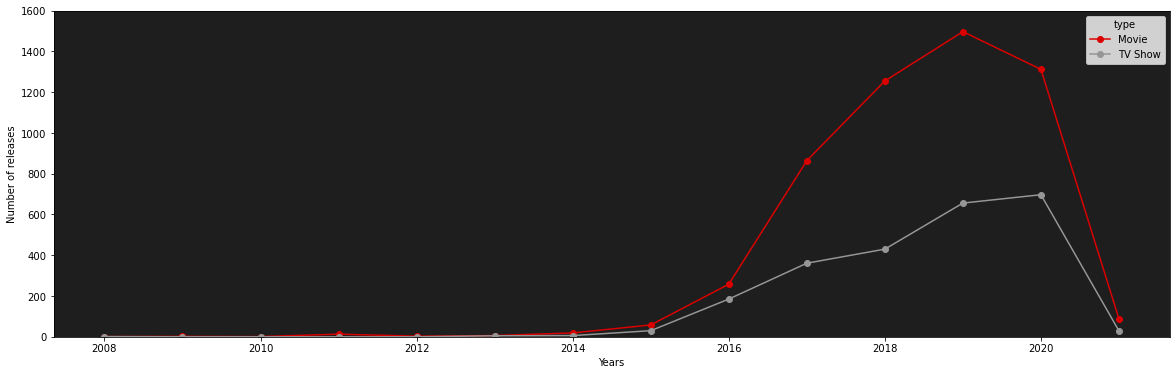

In [143]:
ax = netflix_pivot_year.T.plot(
    kind="line",
    ylim=(0, 1600),
    marker='o',
    color=[theme['red_hex'], theme['light_gray_hex']])
#ax.ylim  = (0, 5000)
fig = ax.get_figure()
fig.set_size_inches(20, 6)
#fig.patch.set_facecolor('black')
locs, labels = plt.xticks()

#plt.xticks( np.arange(4), ('January', 'February', 'March', 'April',  'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December') )
ax.set_xlabel("Years")
ax.set_ylabel("Number of releases")
ax.set_facecolor(theme['dark_gray_hex'])

plt.show()

It seems like the production and aquisition of Netflix shows really took off in 2016, with the company's growth taking a toll in 2020, affected by the Covid-19 pandemic. 

<p>It looks like Netflix choose to focus themselves on movies, rather than TV shows, which seems kind of counterintuitive, because Netflix tends to be known by the TV shows they produce. However, this can be explained by the fact that Netflix usually  buys the rights for lots of successful (or less so ) movies produced by others, and much less so for TV shows, which are more frequently created in-house. </p>
    
 <p> Arguably, one might say that the  TV shows produced in house are way more successful than their movies  (compare <i>Stranger Things, The Crown, The Witcher </i> with movies such as <i>The Platform, The Irishman, Bird Box </i>). <p>

In [144]:
parsed_grouped_movies = grouped_movies.copy()
for index, row in parsed_grouped_movies.iterrows():
    if 'Movies' in str(row['listed_in']) and str(row['listed_in']) != 'Movies':
        strr = str(row['listed_in']).replace('Movies', '')
        row['listed_in'] = strr
        parsed_grouped_movies.at[index, 'listed_in'] = strr

for index, row in parsed_grouped_movies.iterrows():
    if 'Features' in str(
            row['listed_in']) and str(row['listed_in']) != 'Movies':
        strr = str(row['listed_in']).replace('Features', '')
        row['listed_in'] = strr
        parsed_grouped_movies.at[index, 'listed_in'] = strr

for index, row in parsed_grouped_movies.iterrows():
    strr = str(row['listed_in']).strip()
    row['listed_in'] = strr
    parsed_grouped_movies.at[index, 'listed_in'] = strr

parsed_grouped_movies = parsed_grouped_movies.sort_values(by=['listed_in'])
parsed_grouped_movies[0:3]

listed_in  number_of_titles
0  Action & Adventure               977
1               Anime                61
2   Children & Family               657

In [145]:
parsed_grouped_shows = grouped_shows.copy()
for index, row in parsed_grouped_shows.iterrows():
    if 'TV Shows' in str(
            row['listed_in']) and str(row['listed_in']) != 'TV Shows':
        strr = str(row['listed_in']).replace('TV Shows', '')
        row['listed_in'] = strr
        parsed_grouped_shows.at[index, 'listed_in'] = strr


for index, row in parsed_grouped_shows.iterrows():
    if 'TV' in str(row['listed_in']) and str(row['listed_in']) != 'TV Shows':
        strr = str(row['listed_in']).replace('TV', '')
        row['listed_in'] = strr
        parsed_grouped_shows.at[index, 'listed_in'] = strr

    if 'Series' in str(row['listed_in']):
        strr = str(row['listed_in']).replace('Series', '')
        row['country'] = strr
        parsed_grouped_shows.at[index, 'listed_in'] = strr
    if '\'' in str(row['listed_in']):
        strr = str(row['listed_in']).replace('\'', '')
        row['listed_in'] = strr
        parsed_grouped_shows.at[index, 'listed_in'] = strr

    if str(row['listed_in']) == 'Docuseries':
        strr = str(row['listed_in']).replace('Docuseries', 'Documentaries')
        row['listed_in'] = strr
        parsed_grouped_shows.at[index, 'listed_in'] = strr

    if 'Talk Shows' in str(row['listed_in']):
        strr = str(row['listed_in']).replace(' & Talk Shows', '')
        row['listed_in'] = strr
        parsed_grouped_shows.at[index, 'listed_in'] = strr

for index, row in parsed_grouped_shows.iterrows():
    strr = str(row['listed_in']).strip()
    row['listed_in'] = strr
    parsed_grouped_shows.at[index, 'listed_in'] = strr

parsed_grouped_shows = parsed_grouped_shows.sort_values(by=['listed_in'])
parsed_grouped_shows[0:3]

listed_in  number_of_titles
13  Action & Adventure               172
0                Anime               150
1              British               263

In [146]:
shows_genre = parsed_grouped_shows['listed_in'].to_numpy()
movies_genre = parsed_grouped_movies['listed_in'].to_numpy()
common = np.intersect1d(shows_genre, movies_genre)
international_index = common.tolist().index('International')
common = np.delete(common, international_index)

common_items = pd.DataFrame({
    'listed_in': [],
    'movies_count': [],
    'shows_count': []
})

for genre in common:
    g_movies = movies[movies['listed_in'].str.contains(genre)]
    g_shows = shows[shows['listed_in'].str.contains(genre)]

    new_row = {
        'listed_in': genre,
        'movies_count': g_movies.shape[0],
        'shows_count': g_shows.shape[0]
    }
    common_items = common_items.append(new_row, ignore_index=True)

common_items['movies_count'] = common_items['movies_count'].astype(int)
common_items['shows_count'] = common_items['shows_count'].astype(int)

common_items

listed_in  movies_count  shows_count
0  Action & Adventure           721          172
1               Anime            57          150
2            Comedies          1471          508
3       Documentaries           786            0
4              Dramas          2106          707
5              Horror           312           76
6            Romantic           531          294
7    Sci-Fi & Fantasy           218           89
8     Stand-Up Comedy           329           45
9           Thrillers           491           57

In [147]:
fig = go.Figure(data=[
    go.Bar(name='Shows',
           x=common_items['listed_in'],
           y=common_items['shows_count']),
    go.Bar(name='Movies',
           x=common_items['listed_in'],
           y=common_items['movies_count'],
           marker_color=theme['red'])
])

fig.update_layout(barmode='group')
fig.update_layout(height=750)
fig.update_layout(paper_bgcolor=theme['dark_gray'],
                  plot_bgcolor=theme['dark_gray'],
                  font_color="white")
fig.update_layout(title_text='TV Shows versus Movies by genre')
fig.show()

Contrar to what we expected, romantic TV Shows are far less than romantic movies, with the same thing being true for thrillers. 

Our conclusion is that some genres are more attractive to producers rather than others.

### Language analysis

In order to add more technical difficulty, we decided to try a module of language recognition on the shows' title. 

For that, we needed a language-code list, taken from a csv.

In [148]:
language_codes = pd.read_csv('language-codes.csv')
language_codes[0:3]

alpha2    English
0     aa       Afar
1     ab  Abkhazian
2     ae    Avestan

In [149]:
titles = movies['title'].unique()
clean_titles = []
for title in titles:
    result = ''.join([i for i in title if not i.isdigit()])
    if result.strip() != '':
        clean_titles.append(result)

In [150]:
def getLanguageByCode(lang_code):
    result = language_codes[language_codes['alpha2'] == lang_code]['English']
    return result.values[0]

In [ ]:
lang_dict = {}
for clean_title in clean_titles:
    try:
        language = detect(clean_title)
        if language in lang_dict:
            lang_dict[language].append(clean_title)
        else: 
            lang_dict[language] = [clean_title]
            
    except Exception as e:
        print(f'{clean_title} e = {e}') 

: e = No features in text.
: e = No features in text.
, e = No features in text.
' e = No features in text.
/ e = No features in text.
-= e = No features in text.


In [ ]:
parsed_languages = {}
for key, value in lang_dict.items():
    fullname = ''
    if (key == 'zh-cn'):
        fullname = getLanguageByCode('zh')
    else:
        fullname = getLanguageByCode(key)

    parsed_languages[fullname] = value

In [ ]:
parsed_languages = {}
for key, value in lang_dict.items():
    fullname = ''
    if (key == 'zh-cn'):
        fullname = getLanguageByCode('zh')
    else:
        fullname = getLanguageByCode(key)

    parsed_languages[fullname] = value

In [ ]:
languages_df = pd.DataFrame({'language': [], 'movies_count': []})
total_movies = 0
for key, value in parsed_languages.items():
    total_movies = total_movies + len(value)

for key, value in parsed_languages.items():
    percentage = (len(value) / total_movies) * 100
    percentage = round(percentage, 3)
    new_row = {'language': key, 'movies_count': percentage}
    languages_df = languages_df.append(new_row, ignore_index=True)
    
normalized_df.round({'total_movies': 2})
languages_df = languages_df.sort_values(by=['movies_count'], ascending=True)

fig = go.Figure(
    go.Bar(x=languages_df['movies_count'],
           y=languages_df['language'],
           orientation='h',
           marker_color=theme['red']))

fig.update_layout(height=700)
fig.update_layout(paper_bgcolor=theme['dark_gray'],
                  plot_bgcolor=theme['dark_gray'],
                  font_color="white")
fig.update_layout(title_text='Most popular languages on Netflix')
fig.show()

It comes to nobody's surprise that english is the most popular language on Netflix. However, we would've expected that Spanish is the second most popular language, given the company's presence in South America. However, after carefully analysing the outputs, we see that spanish is split into dialects - castillan, valencian and catalan. 

Another constraint of the language detection framework is that hindi is often confused with Indonesian, Somali or Tagalog. 

In [ ]:
genres = ['Romantic Movies']
# , 'International Movies', 'Comedies', 'Thrillers', 'Action & Adventure']
for genre in genres:
    titles = movies[movies['listed_in'] == genre]['title'].unique()
    len(titles)
    clean_titles = []
    for title in titles:
        result = ''.join([i for i in title if not i.isdigit()])
        if result.strip() != '':
            clean_titles.append(result)

    lang_dict = {}
    for clean_title in clean_titles:
        try:
            language = detect(clean_title)
            if language in lang_dict:
                lang_dict[language] = lang_dict[language] + 1
            else:
                lang_dict[language] = 1
        except:
            print("")

    parsed_languages = {}
    for key, value in lang_dict.items():
        fullname = ''
        if (key == 'zh-cn'):
            fullname = getLanguageByCode('zh')
        else:
            fullname = getLanguageByCode(key)

        parsed_languages[fullname] = value

    languages_df = pd.DataFrame({'language': [], 'movies_count': []})
    total_movies = 0
    for key, value in parsed_languages.items():
        total_movies = total_movies + value

    for key, value in parsed_languages.items():
        percentage = (value / total_movies) * 100
        percentage = round(percentage, 3)
        new_row = {'language': key, 'movies_count': percentage}
        languages_df = languages_df.append(new_row, ignore_index=True)

    normalized_df.round({'total_movies': 2})
    languages_df = languages_df.sort_values(by=['movies_count'],
                                            ascending=True)

    fig = go.Figure(
        go.Bar(x=languages_df['movies_count'],
               y=languages_df['language'],
               orientation='h',
               marker_color=theme['red']))

    fig.update_layout(height=700)
    fig.update_layout(paper_bgcolor=theme['dark_gray'],
                      plot_bgcolor=theme['dark_gray'],
                      font_color="white")
    fig.update_layout(title_text='Language distribution for Romantic Movies')

    fig.show()

In [ ]:
titles = shows['title'].unique()

In [ ]:
clean_titles = []
for title in titles:
    result = ''.join([i for i in title if not i.isdigit()])
    if result.strip() != '':
        clean_titles.append(result)

lang_dict = {}
for clean_title in clean_titles:
    try:
        language = detect(clean_title)
        if language in lang_dict:
            lang_dict[language].append(clean_title)
        else:
            lang_dict[language] = [clean_title]

    except Exception as e:
        print(f'{clean_title} e = {e}')

parsed_languages = {}
for key, value in lang_dict.items():
    fullname = ''
    if (key == 'zh-cn'):
        fullname = getLanguageByCode('zh')
    else:
        fullname = getLanguageByCode(key)

    parsed_languages[fullname] = value

languages_df = pd.DataFrame({'language': [], 'movies_count': []})
total_movies = 0
for key, value in parsed_languages.items():
    total_movies = total_movies + len(value)

for key, value in parsed_languages.items():
    percentage = (len(value) / total_movies) * 100
    percentage = round(percentage, 3)
    new_row = {'language': key, 'movies_count': percentage}
    languages_df = languages_df.append(new_row, ignore_index=True)

normalized_df.round({'total_movies': 2})
languages_df = languages_df.sort_values(by=['movies_count'], ascending=True)

fig = go.Figure(
    go.Bar(x=languages_df['movies_count'],
           y=languages_df['language'],
           orientation='h',
           marker_color=theme['red']))

fig.update_layout(height=700)
fig.update_layout(paper_bgcolor=theme['dark_gray'],
                  plot_bgcolor=theme['dark_gray'],
                  font_color="white")

fig.update_layout(title_text='Language distribution for TV Shows')
fig.show()

### Actors analysis

In order to dig further down into the world of Netflix, there was this one analysis waiting to be done - what about the human beings making this kind of entertainment possible ?

We decided to extract only the productions from the United States which have cast information, because we are more familiar with their names, given that the american movie culture is the most popular in Europe.

In [114]:
by_cast = dataframe[['title', 'country', 'cast']].copy()
by_cast = by_cast[(by_cast['cast'].notnull())
                  & (by_cast['country'] == 'United States')]

The cast column is made up of actor names separated by commas. We need to separate them and also remove whitespace.

In [115]:
by_cast['cast'] = by_cast['cast'].apply(lambda row_value: list(
    map(lambda actor_name: actor_name.strip(), str(row_value).split(","))))

Let's split the cast arrays into separate rows by using explode.

In [116]:
all_actors = by_cast.explode("cast")
all_actors[0:3]

title        country               cast
3     9  United States        Elijah Wood
3     9  United States     John C. Reilly
3     9  United States  Jennifer Connelly

Now we can count the number of productions each actor starred in

In [117]:
cast_counts = all_actors.groupby(by='cast', as_index=False).agg(number_prods=('cast', 'count'))
sorted_cast_counts = cast_counts.copy().sort_values(['number_prods'], ascending=False).reset_index(drop=True)
sorted_cast_counts[0:3]

cast  number_prods
0       Adam Sandler            19
1  Samuel L. Jackson            16
2    Fred Tatasciore            16

In [118]:
fig = go.Figure(data=[
    go.Bar(y=sorted_cast_counts[:30].cast,
           x=sorted_cast_counts[:30]['number_prods'],
           marker_color=theme['red'],
           orientation='h')
])
fig.update_layout(paper_bgcolor=theme['dark_gray'],
                  plot_bgcolor=theme['dark_gray'],
                  font_color="white",
                  title_text="Most popular actors from US",
                  width=800,
                  height=800)
fig.update_yaxes(autorange="reversed")
fig.update_xaxes(side="top")
fig.show()

Using cast counts, we can extract the actors which are part of at least 5 productions (in order to not have too much data).
We will also extract these actor names in an array and into a map of indices.

In [119]:
popular_actors = cast_counts[cast_counts['number_prods'] > 5]

popular_actors_list = popular_actors['cast'].values
popular_map = dict(zip(popular_actors_list, range(len(popular_actors_list))))
popular_map_inv = dict(zip(range(len(popular_actors_list)), popular_actors_list))


Now we need to compute a matrix of occurences that for each actor will say in how many movies he or she has player with all the other actors. It's size will be `num_of_actors * num_of_actors` 

In [120]:
# Create a new empty matrix for occurences between actors
matrix = np.zeros((len(popular_actors_list), len(popular_actors_list)))

for i in by_cast.index:
    # Get the current movie cast
    current_group = by_cast['cast'][i]

    # Extract actors which are part of popular list
    current_group = filter(lambda x: x in popular_actors_list, current_group)

    # Convert actor names into indices
    indices = list(map(lambda x: popular_map[x], current_group))

    # Get all the permutations of actors in pairs
    # Example: [x, y, z] => [[x, y], [x, z], [y, x], [y, z], [z, x], [z, y]]
    pairs = list(itertools.permutations(indices, 2))

    # Use each pair of actors to update the matrix of occurences
    for pair in pairs:
        matrix[pair[0], pair[1]] += 1
        
print(matrix.shape)
print(len(popular_actors_list))

(300, 300)
300


In [121]:
to_drop = []
for i in range(len(popular_actors_list)):
    nb_collaborations = np.sum(matrix[:, i])
    if nb_collaborations < 15:
        to_drop.append(i)

matrix = np.delete(matrix,to_drop, axis = 0)
matrix = np.delete(matrix,to_drop, axis = 1)
popular_actors_list = np.delete(popular_actors_list, to_drop, axis=0)

In [122]:
adj_matrix_with_names = pd.DataFrame(matrix, index=popular_actors_list, columns=popular_actors_list)
adj_matrix_with_names[0:3]

Adam Sandler  Adam Scott  Alex Heartman  Alison Brie  \
Adam Sandler            0.0         0.0            0.0          0.0   
Adam Scott              0.0         0.0            0.0          1.0   
Alex Heartman           0.0         0.0            0.0          0.0   

               Allen Covert  America Ferrera  America Young  Amy Poehler  \
Adam Sandler            6.0              0.0            0.0          0.0   
Adam Scott              0.0              0.0            0.0          2.0   
Alex Heartman           0.0              0.0            0.0          0.0   

               Amy Sedaris  Andrew Bachelor  ...  Taye Diggs  Terrence Howard  \
Adam Sandler           0.0              0.0  ...         0.0              0.0   
Adam Scott             0.0              0.0  ...         0.0              0.0   
Alex Heartman          0.0              0.0  ...         0.0              0.0   

               Terry Crews  Tiffany Haddish  Tony Hale  Tracy Morgan  \
Adam Sandler           2.0              0.0        0.0           0.0   
Adam Scott             0.0              0.0        0.0           0.0   
Alex Heartman          0.0              0.0        0.0           0.0   

               Will Arnett  Will Ferrell  Will Forte  Zach Galifianakis  
Adam Sandler           0.0           0.0         1.0                0.0  
Adam Scott             0.0           1.0         1.0                0.0  
Alex Heartman          0.0           0.0         0.0                0.0  

[3 rows x 168 columns]

In [123]:
def get_collaborations_for_actor(actor_name, adj_matrix, actors_map):
    actor_idx = actors_map[actor_name]
    collabs = adj_matrix[actor_idx]
    collabs_df = pd.DataFrame(list(zip(actors_map.keys(), collabs)),
                              columns=['actor_name', 'collabs'])
    collabs_df = collabs_df[collabs_df['collabs'] > 0].sort_values(
        by='collabs', ascending=False)

    return collabs_df


actor_name = "Andy Samberg"
collabs = get_collaborations_for_actor(actor_name, matrix, popular_map)

fig = go.Figure(data=[
    go.Bar(y=collabs['collabs'],
           x=collabs['actor_name'],
           marker_color=theme['red'])
])

fig.update_xaxes(tickangle=300,
                 title_text="Actor name",
                 title_font={"size": 20})
fig.update_yaxes(title_text="Number of collaborations",
                 title_font={"size": 20})
fig.update_layout(
    title={
        'text': f"Total collaborations of {actor_name}",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    font_color='white',
    paper_bgcolor=theme['dark_gray'],
    plot_bgcolor=theme['dark_gray'],
)
fig.show()

In [124]:
graph = nx.from_pandas_adjacency(adj_matrix_with_names)
pos_ = nx.spring_layout(graph)

In [125]:
def make_edge(x, y, text, width):
    return go.Scatter(x=x,
                      y=y,
                      line=dict(width=width, color='red'),
                      hoverinfo='text',
                      text=([text]),
                      mode='lines')


edge_trace = []
for edge in graph.edges():

    if graph.edges()[edge]['weight'] > 0:
        char_1 = edge[0]
        char_2 = edge[1]

        x0, y0 = pos_[char_1]
        x1, y1 = pos_[char_2]

        text = char_1 + '--' + char_2 + ': ' + str(
            graph.edges()[edge]['weight'])

        trace = make_edge([x0, x1, None], [y0, y1, None], text,
                          0.5 * graph.edges()[edge]['weight'])

        edge_trace.append(trace)

In [126]:
node_trace = go.Scatter(x=[],
                        y=[],
                        text=[],
                        textposition="top center",
                        textfont_size=10,
                        mode='markers+text',
                        hoverinfo='none',
                        marker=dict(color=[], size=[], line=None))

for node in graph.nodes():
    x, y = pos_[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['marker']['color'] += tuple(['red'])
    node_trace['marker']['size'] += tuple([8])
    node_trace['text'] += tuple([node])

In [127]:
layout = go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')

fig = go.Figure(layout=layout)

for trace in edge_trace:
    fig.add_trace(trace)

fig.add_trace(node_trace)
fig.update_layout(showlegend=False)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

## Customer feedback

One of the most important parts of every business is the final user feedback. That's why we needed some ratings from the viewers. 

In [128]:
netflix_df_2 = dataframe.copy()
netflix_df_2['type_name'] = netflix_df_2['type']
netflix_df_2['type'].replace(to_replace=['TV Show', 'Movie'], value=[1, 2], inplace=True)
netflix_df_2

show_id  type                                    title  \
0         s1     1                                       3%   
1         s2     2                                     7:19   
2         s3     2                                    23:59   
3         s4     2                                        9   
4         s5     2                                       21   
...      ...   ...                                      ...   
7782   s7783     2                                     Zozo   
7783   s7784     2                                   Zubaan   
7784   s7785     2                        Zulu Man in Japan   
7785   s7786     1                    Zumbo's Just Desserts   
7786   s7787     2  ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS   

               director                                               cast  \
0                   NaN  João Miguel, Bianca Comparato, Michel Gomes, R...   
1     Jorge Michel Grau  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...   
2          Gilbert Chan  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...   
3           Shane Acker  Elijah Wood, John C. Reilly, Jennifer Connelly...   
4        Robert Luketic  Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...   
...                 ...                                                ...   
7782        Josef Fares  Imad Creidi, Antoinette Turk, Elias Gergi, Car...   
7783        Mozez Singh  Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...   
7784                NaN                                            Nasty C   
7785                NaN                         Adriano Zumbo, Rachel Khoo   
7786           Sam Dunn                                                NaN   

                                                country          date_added  \
0                                                Brazil     August 14, 2020   
1                                                Mexico   December 23, 2016   
2                                             Singapore   December 20, 2018   
3                                         United States   November 16, 2017   
4                                         United States     January 1, 2020   
...                                                 ...                 ...   
7782  Sweden, Czech Republic, United Kingdom, Denmar...    October 19, 2020   
7783                                              India       March 2, 2019   
7784                                                NaN  September 25, 2020   
7785                                          Australia    October 31, 2020   
7786              United Kingdom, Canada, United States       March 1, 2020   

      release_year rating   duration  \
0             2020  TV-MA  4 Seasons   
1             2016  TV-MA     93 min   
2             2011      R     78 min   
3             2009  PG-13     80 min   
4             2008  PG-13    123 min   
...            ...    ...        ...   
7782          2005  TV-MA     99 min   
7783          2015  TV-14    111 min   
7784          2019  TV-MA     44 min   
7785          2019  TV-PG   1 Season   
7786          2019  TV-MA     90 min   

                                              listed_in  \
0     International TV Shows, TV Dramas, TV Sci-Fi &...   
1                          Dramas, International Movies   
2                   Horror Movies, International Movies   
3     Action & Adventure, Independent Movies, Sci-Fi...   
4                                                Dramas   
...                                                 ...   
7782                       Dramas, International Movies   
7783     Dramas, International Movies, Music & Musicals   
7784  Documentaries, International Movies, Music & M...   
7785                 International TV Shows, Reality TV   
7786                    Documentaries, Music & Musicals   

                                            description type_name  
0     In a future where the elite inhabit an island ...   TV Show  
1     After a devastating earthquake

In [129]:
ratings_from_imdb = pd.read_csv('IMDb_ratings.csv')
titles_from_imdb = pd.read_csv('IMDb_movies.csv')

C:\Users\flori\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.



In [130]:
ratings_df = pd.DataFrame({
    'title': titles_from_imdb.title,
    'rating': ratings_from_imdb.weighted_average_vote,
    'genre': titles_from_imdb.genre,
    'year': titles_from_imdb.year
})

ratings_df.drop_duplicates(subset=['title', 'year', 'genre'], inplace=True)
ratings_df.dropna()

title  rating                      genre  year
0                          Miss Jerry     5.9                    Romance  1894
1         The Story of the Kelly Gang     6.1    Biography, Crime, Drama  1906
2                      Den sorte drøm     5.8                      Drama  1911
3                           Cleopatra     5.2             Drama, History  1912
4                           L'Inferno     7.0  Adventure, Drama, Fantasy  1911
...                               ...     ...                        ...   ...
85850                         Le lion     5.3                     Comedy  2020
85851  De Beentjes van Sint-Hildegard     7.7              Comedy, Drama  2020
85852       Padmavyuhathile Abhimanyu     7.9                      Drama  2019
85853               Sokagin Çocuklari     6.4              Drama, Family  2019
85854      La vida sense la Sara Amat     6.7                      Drama  2019

[85843 rows x 4 columns]

For now, there are is a much bigger number of movies than TV shows in the Netflix catalogue. However, this thing is starting to change as the available time for watching TV shrinks. People nowadays have less and less consecutive minutes to watch TV because of the busy schedule of the modern world. That translates into a higher interest for TV shows, because it's much more feasible to find 50 free minutes every night rather than 100 consecutive minutes (the average length of a movie).  <a href="https://www.cinemablend.com/television/2486360/netflix-now-has-more-tv-shows-but-fewer-movies-than-5-years-ago-smart-trend" target="_blank">Source</a> 

We've decided to search the most appreciated shows currenty on Netflix. We considered that Imdb is a relevant source for ratings given by users, so we downloaded a CSV with the ratings from <a href="https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset" target="_blank">Kaggle</a>. 

<p> Afterwards, we joined the two dataframes by the shows' title and that's how we found the first 15 most appreciated shows by Netflix fans all around the world </p>

In [131]:
netflix_imdb = ratings_df.merge(dataframe,
                                left_on='title',
                                right_on='title',
                                how='inner')
netflix_imdb = netflix_imdb.sort_values(by='rating_x', ascending=False)
netflix_imdb['country'] = np.where((netflix_imdb.title == 'Breakout'),
                                   'Singapore', netflix_imdb.country)
netflix_imdb.dropna()

title  rating_x                      genre  year  \
990                 Innocent       9.0                     Comedy  2017   
397             Pulp Fiction       8.9               Crime, Drama  1994   
379         Schindler's List       8.9  Biography, Drama, History  1993   
1298               Inception       8.8  Action, Adventure, Sci-Fi  2010   
1664  Much Ado About Nothing       8.6            Comedy, Romance  2011   
...                      ...       ...                        ...   ...   
844                The Vault       1.9                     Action  2005   
581               Himmatwala       1.7             Action, Comedy  2013   
1685     Welcome to New York       1.6              Comedy, Drama  2018   
2188                 Aerials       1.6    Drama, Sci-Fi, Thriller  2016   
1203                    Pink       1.6              Comedy, Drama  2016   

     show_id     type                       director  \
990    s3009  TV Show                     Seren Yüce   
397    s5003    Movie              Quentin Tarantino   
379    s5431    Movie               Steven Spielberg   
1298   s2980    Movie              Christopher Nolan   
1664   s4266    Movie  Alejandro Fernández Almendras   
...      ...      ...                            ...   
844    s6978    Movie                       Dan Bush   
581    s2744    Movie                     Sajid Khan   
1685   s7528    Movie                   Abel Ferrara   
2188    s319    Movie                     S.A. Zaidi   
1203   s4863    Movie        Aniruddha Roy Chowdhury   

                                                   cast  \
990   Ali Atay, Haluk Bilginer, Nur Sürer, Okan Yala...   
397   John Travolta, Samuel L. Jackson, Uma Thurman,...   
379   Liam Neeson, Ben Kingsley, Ralph Fiennes, Caro...   
1298  Leonardo DiCaprio, Joseph Gordon-Levitt, Ellen...   
1664  Agustín Silva, Paulina García, Daniel Alcaíno,...   
...                                                 ...   
844   Taryn Manning, Francesca Eastwood, James Franc...   
581   Ajay Devgn, Tamannaah Bhatia, Paresh Rawal, Za...   
1685  Gérard Depardieu, Jacqueline Bisset, Marie Mou...   
2188  Saga Alyasery, Ana Druzhynina, Mansour Al Fele...   
1203  Tapsee Pannu, Kirti Kulhari, Andrea Tariang, A...   

                            country        date_added  release_year rating_y  \
990                          Turkey  January 23, 2019          2017    TV-MA   
397                   United States   January 1, 2019          1994        R   
379                   United States     April 1, 2018          1993        R   
1298  United States, United Kingdom   January 1, 2020          2010    PG-13   
1664   Chile, United States, France   October 1, 2016          2016    TV-MA   
...                             ...               ...           ...      ...   
844                   United States   January 1, 2018          2017    TV-MA   
581                           India  November 1, 2018          2013    TV-14   
1685          United States, France    March 23, 2017          2014        R   
2188           United Arab Emirates       May 7, 2020          2016    TV-14   
1203                          India  January 20, 2017          2016    TV-14   

      duration                                          listed_in  \
990   1 Season  Crime TV Shows, International TV Shows, TV Dramas   
397    154 min                Classic Movies, Cult Movies, Dramas   
379    195 min                             Classic Movies, Dramas   
1298   148 min    Action & Adventure, Sci-Fi & Fantasy, Thrillers   
1664    96 min   Dramas, Independent Movies, International Movies   
...        ...                                                ...   
844     92 min                           Horror Movies, Thrillers   
581    140 min  Action & Adventure, Comedies, International Mo...   
1685   108 min                         Dramas, Independent Movies   
2188    90 min             International Movies, Sci-Fi & Fantasy   
1203   130 min      

<i> Breakout </i>, one of the most appreciated TV Series currently on Netflix, had no country of origin in the initial Netflix dataframe. So, in order for the plot to look nice, we manually added the country where it was produced - which is Singapore.

In [132]:
fig = px.sunburst(
    netflix_imdb[0:15],
    path=['title','country'],
    values='rating_x',
    color='rating_x')
fig.show()

We think the most suprising part of this plot is the batch of Indian shows with a rating of around 8.5 or 8.6. The Netflix investments in India have payed off, the shows filmed there having a very high rating on Imdb. 

<p> Another interesting thing is that the high rated foreign (non-european or US shows) have not got into the european culture. We for instance, never heard of the highest rated shows on Netflix (Innocent and Breakout), even though <i>Pulp Fiction, Schindler's List </i> and <i>Inception</i> (3rd, 4th and 5th placed are considered classics in the european culture). Judging by the Imdb rating, this shows must be good, but they are struggling to become known into the european space. </p>

## What about Romania ?

In [133]:
ro_movies = counts_by_year_and_country[counts_by_year_and_country['country'] == "Romania"].copy()
ro_movies['added_year'] = ro_movies['added_year'].astype(str)
ro_movies

country  number_of_titles added_year
60  Romania                 1       2018
70  Romania                 1       2019
75  Romania                 7       2020
85  Romania                12       2021

In [134]:
fig = go.Figure(data=[
    go.Bar(x=ro_movies['added_year'],
           y=ro_movies['number_of_titles'],
           marker_color=theme['red'])
])
fig.update_layout(
    paper_bgcolor=theme['dark_gray'],
    plot_bgcolor=theme['dark_gray'],
    font_color="white",
    title={
        'text': "Netflix titles added every year produced by Romania",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
)
fig.show()

In [135]:
movies_in_romania = movies[movies['country'] == 'Romania']
movies_in_romania[0:3]

show_id   type       title        director  \
36      s37  Movie     #Selfie  Cristina Jacob   
37      s38  Movie  #Selfie 69  Cristina Jacob   
124    s125  Movie       5Gang      Matei Dima   

                                                  cast  country  \
36   Flavia Hojda, Crina Semciuc, Olimpia Melinte, ...  Romania   
37   Maia Morgenstern, Olimpia Melinte, Crina Semci...  Romania   
124  Andrei Selaru, Dorian Popa, Julia Marcan, Ana ...  Romania   

         date_added  release_year rating  duration  \
36     June 1, 2019          2014  TV-MA       125   
37     June 1, 2019          2016  TV-MA       119   
124  April 27, 2020          2019  TV-14        96   

                                  listed_in  \
36   Comedies, Dramas, International Movies   
37   Comedies, Dramas, International Movies   
124          Comedies, International Movies   

                                           description added_datetime  \
36   Two days before their final exams, three teen ...     2019-06-01   
37   After a painful breakup, a trio of party-lovin...     2019-06-01   
124  To keep the band together, Selly tries to earn...     2020-04-27   

     added_year  
36         2019  
37         2019  
124        2020

In [136]:
movies_in_romania = movies_in_romania.groupby(
    by='listed_in', as_index=False).agg(number_of_titles=('listed_in', 'count'))
movies_in_romania[0:3]

listed_in  number_of_titles
0  Comedies, Dramas, International Movies                 2
1          Comedies, International Movies                 2
2            Dramas, International Movies                 1

In [137]:
import plotly.express as px
fig = px.pie(movies_in_romania,
             values='number_of_titles',
             names='listed_in',
             color='listed_in',
             color_discrete_map={
                 'International Movies': theme['red'],
                 'Thrillers': theme['dark_gray'],
                 'Romantic Movies': theme['light_gray']
             })
fig.update_layout(title_text='Genre analysis for Romania')
fig.show()